In [50]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy as sp
from mpl_toolkits import mplot3d
import ellipses as el
from matplotlib.patches import Ellipse
%matplotlib inline
# helper functions
# ellipse fitting function
def efit(data, right=True):
    lsqe = el.LSqEllipse()
    lsqe.fit(data)
    center, width, height, phi = lsqe.parameters()
    plt.close('all')
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(data[0], data[1], 'ro', label='test data', zorder=1)
    ax.imshow(imgEye[0], cmap='gray')
    plt.plot(maxpR[1], maxpR[0], 'y+')
    ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
                   edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
    ax.add_patch(ellipse)
    arrow = plt.Arrow(x=maxpR[1], y=maxpR[0], dx=center[0]-maxpR[1], dy=center[1]-maxpR[0], width=30)
    ax.add_patch(arrow)
    vector = [(center[0]-maxpR[1]), (center[1]-maxpR[0])]
    vecmag = np.sqrt(vector[0]**2+vector[1]**1)
    plt.title('Gaze Vector Mag = '+str(round(vecmag,1))+' pixels')
    plt.plot(center[0],center[1], 'g+')
    plt.legend()
    plt.show()
    plt.savefig('r20.jpg')
    return (center, vector)
# remove noise
def debubble(cpos, cneg, rpos, rneg, win_):
#     input: xcor of edge points
#     ncol: number of column
#     posfirst: posedge happens before negedge
    counts = np.bincount(cpos)
    pmode = np.argmax(counts)
    counts2 = np.bincount(cneg)
    nmode = np.argmax(counts2)
    ta1 = np.zeros(len(cpos)).astype('bool')
    ta2 = np.zeros(len(cneg)).astype('bool')
    print('truncation: ', pmode, '+-', win_)
    print('truncation: ', nmode, '+-', win_)
    for i in range(len(cpos)):
        ta1[i] = (cpos<(pmode+win_))[i] and (cpos>(pmode-win_))[i]
        ta2[i] = (cneg<(nmode+win_))[i] and (cneg>(nmode-win_))[i]
    return cpos[ta1], cneg[ta2], rpos[ta1], rneg[ta2]
# parameters:
zoomout = 1.1
ratio = 1/4
narrower = 0
pns = 200
nns = 400
win = 10 # bilateral window size in pixel
print ('modules imported')

modules imported


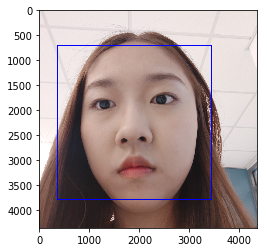

In [51]:
#   faces eyes detection
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier("haarcascade_eye.xml")
if (eye_cascade.empty()==True or face_cascade.empty()==True):
    print ('Fail to load xml data')
imgEye = []
img = cv.imread('t20.jpeg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
if(len(faces) == 0):
    print("Face dectection failure")
for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),20)
    roi_gray = gray[y:y+h, x:x+w]
    plt.imshow(roi_gray,cmap='gray')
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
#         cv.rectangle(roi_color,(ex,ey),(ex+(int)(ew*1.4),ey+(int)(eh*1.4)),(0,255,0),10)
        imgEye.append(cv.cvtColor(roi_color[ey+narrower:ey+(int)(ew), ex:ex+(int)(eh*zoomout)], cv.COLOR_BGR2GRAY))

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.savefig('face20.jpg')

In [52]:
# KL tracking


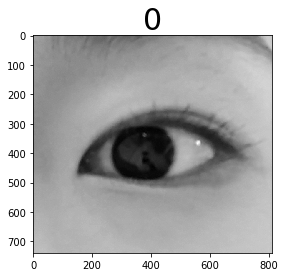

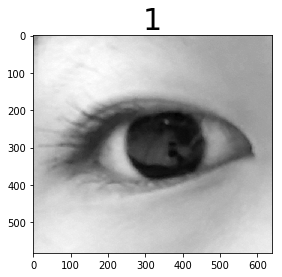

In [53]:
#  export eyes' img
imgEye = [imgEye[2],imgEye[3]] # manually delete wrong pic
if(len(imgEye) == 0): print('Fail to detect eyes')
for i in range (len(imgEye)):
    fig = plt.figure()
    plt.imshow(imgEye[i], cmap='gray')
    plt.title(str(i),fontsize=30)

right eye filter:
[[-1 -1 -1  1  1  1]
 [-1 -1 -1 -1  1  1]
 [-1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1  1]]
left  eye filter:
[[ 1  1  1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1]]


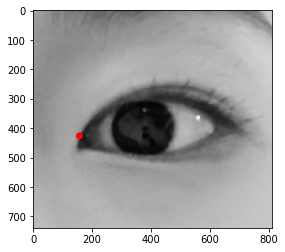

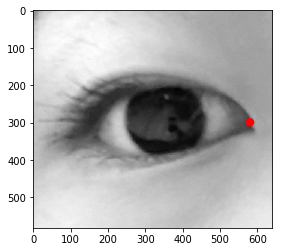

In [54]:
#  eye corner localization 
cfR = np.array([[-1,-1,-1,1,1,1],[-1,-1,-1,-1,1,1],[-1,-1,-1,-1,-1,1],[1,1,1,1,1,1]])
cfL = np.array([[1,1,1,-1,-1,-1],[1,1,-1,-1,-1,-1],[1,-1,-1,-1,-1,-1],[1,1,1,1,1,1]])
print('right eye filter:')
print (cfR)
print('left  eye filter:')
print (cfL)
foR = sg.convolve2d(imgEye[0][:,:(int)(imgEye[0].shape[1]*ratio)], cfR, mode='valid')
foL = sg.convolve2d(imgEye[1][:,-(int)(imgEye[1].shape[1]*ratio):], cfL, mode='valid')
maxpR = np.array([(int) (np.argmax(foR)/foR.shape[1]), np.argmax(foR)%foR.shape[1]])
maxpL = np.array([(int) (np.argmax(foL)/foL.shape[1]), np.argmax(foL)%foL.shape[1]])
maxpL[1] = maxpL[1] + (int)(imgEye[1].shape[1]*3/4)

fig, ax = plt.subplots(1)
ax.imshow(imgEye[0],cmap='gray')
ax.add_patch(plt.Circle((maxpR[1], maxpR[0]), radius=10, color='red'))
fig, ax = plt.subplots(1)
ax.imshow(imgEye[1],cmap='gray')
ax.add_patch(plt.Circle((maxpL[1], maxpL[0]), radius=10, color='red'))
plt.figure()

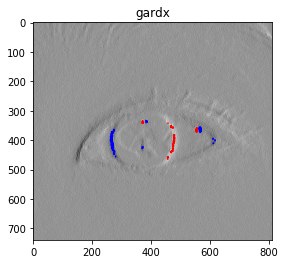

In [59]:
gradx = cv.Sobel(imgEye[0],cv.CV_64F,1,0,ksize=5)
gradx_ = gradx.copy()

gradx = gradx[:,(int)(imgEye[0].shape[1]*ratio):]
row, col = gradx.shape[0], gradx.shape[1]
fig, ax = plt.subplots(1)
ax.imshow((gradx_),cmap='gray')
plt.title('gardx')

ranks = np.argsort(gradx.flatten())
cargp = (ranks[-pns:] % col).astype('int')
rargp = (ranks[-pns:] / col).astype('int')
cargp += (int) ((imgEye[0].shape[1])*ratio)
for i in range(pns):
    ax.add_patch(plt.Circle((cargp[i], rargp[i]), radius=1, color='red'))
cargn = (ranks[0:nns] % col).astype('int')
rargn = (ranks[0:nns] / col).astype('int')
cargn += (int)((imgEye[0].shape[1])*ratio)
for i in range(nns):
    ax.add_patch(plt.Circle((cargn[i], rargn[i]), radius=1, color='blue'))

truncation:  479 +- 10
truncation:  267 +- 10


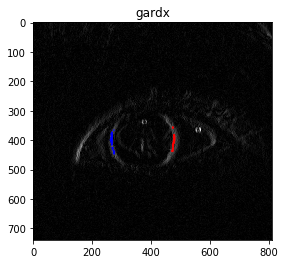

In [56]:
cargp_, cargn_, rargp_, rargn_ = debubble(cargp, cargn, rargp, rargn, win)
fig, ax = plt.subplots(1)
ax.imshow(abs(gradx_),cmap='gray')
plt.title('gardx')
for i in range(len(cargn_)):
    ax.add_patch(plt.Circle((cargn_[i], rargn_[i]), radius=1, color='blue'))
for i in range(len(cargp_)):
    ax.add_patch(plt.Circle((cargp_[i], rargp_[i]), radius=1, color='red'))

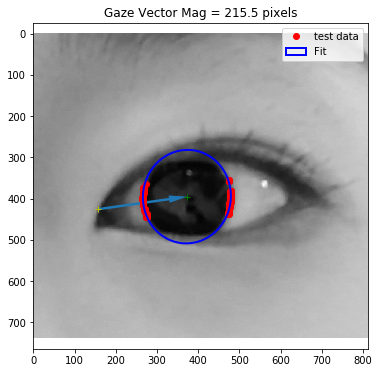

([372.5596044642123, 395.47267811348667],
 [215.55960446421233, -30.527321886513334])

In [57]:
xcor = np.append(cargp_, cargn_)
ycor = np.append(rargp_, rargn_)
efit ([xcor, ycor])

t20 [215, -27] mag = 215.7

t21 [260, -18] mag = 260.8

t22 [217, 25]  mag = 217.4

t23 [263, 32]  mag = 263.4
